In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN


2023-10-29 14:54:44.031384: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 14:54:44.214921: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 14:54:44.214953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 14:54:44.215824: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 14:54:44.303508: I tensorflow/core/platform/cpu_feature_g

In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.857156  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.744531  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.769826  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.773995  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.770458  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1246  2019-12-20     0.775477  70.557503  70.662498  69.639999  69.860001   
1247  2019-12-23     0.759453  70.132500  71.062500  70.092499  71.000000   
1248  2019-12-24     0.742264  71.172501  71.222504  70.730003  71.067497   
1249  2019-12-26     0.670220  71.205002  72.495003  71.175003  72.477501   
1250  2019-12-27     0.760582  72.779999  73.492500  72.029999  72.449997   

      unrate  psr       m2    dspic      pce    reer       

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [17]:
X_train=X[0:1220,:]
X_test=X[1220:,:]
y_train=y[0:1220,:]
y_test=y[1220:,:]

#early stopping

2023-10-29 14:54:46.520117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 14:54:46.612448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 14:54:46.612491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 14:54:46.616695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 14:54:46.616763: I tensorflow/compile

Epoch 1/1000


2023-10-29 14:54:50.292226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-29 14:54:51.284675: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-10-29 14:54:51.284705: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-29 14:54:51.284760: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-29 14:54:51.399909: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-10-29 14:54:51.566995: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_k

10/10 [==============================] - 6s 84ms/step - loss: 2.0305 - val_loss: 0.4037
Epoch 2/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.3519 - val_loss: 0.0207
Epoch 3/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.2064 - val_loss: 0.1228
Epoch 4/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.4814 - val_loss: 0.3903
Epoch 5/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.3374 - val_loss: 0.1207
Epoch 6/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0898 - val_loss: 0.1002
Epoch 7/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.0238
Epoch 8/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0238 - val_loss: 0.0150
Epoch 9/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 10/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 0.0031
Ep

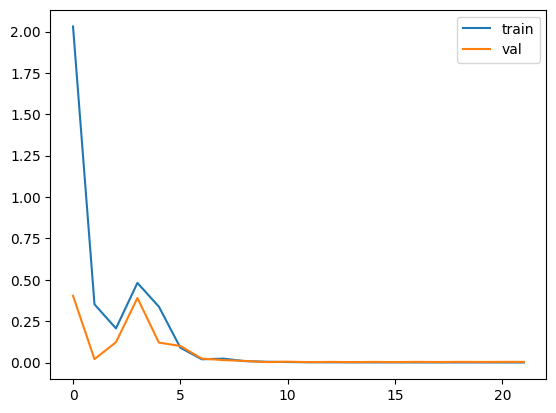

1/1 [==============================] - 0s 220ms/step
MSE: 562.3984610005248
RMSE: 23.71494172458631
(30,)
(30,)


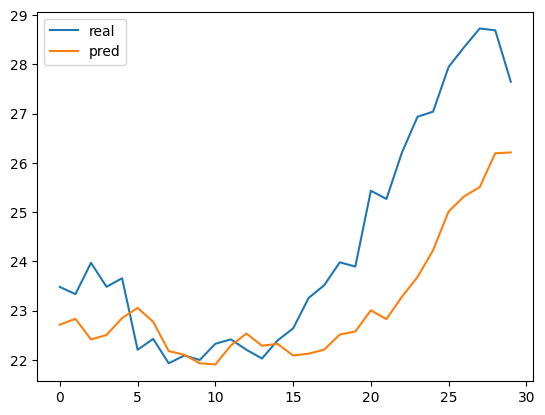

Epoch 1/1000
20/20 [==============================] - 3s 41ms/step - loss: 0.5817 - val_loss: 0.4790
Epoch 2/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.1729 - val_loss: 0.1772
Epoch 3/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3332 - val_loss: 0.6627
Epoch 4/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.2152 - val_loss: 0.1398
Epoch 5/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.1263 - val_loss: 0.0797
Epoch 6/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1490 - val_loss: 0.2216
Epoch 7/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.4825 - val_loss: 0.0648
Epoch 8/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0336
Epoch 9/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.1220 - val_loss: 0.0168
Epoch 10/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.0569 - val_loss: 0.075

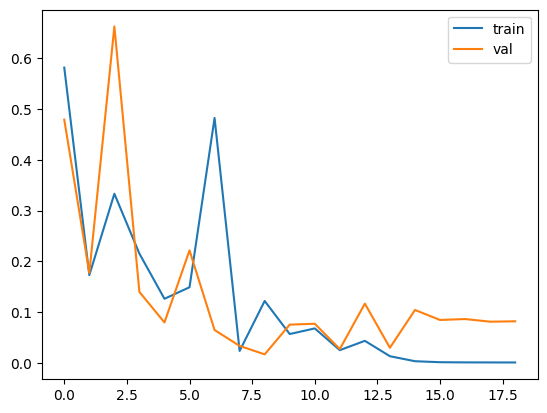

1/1 [==============================] - 0s 132ms/step
MSE: 537.789868456771
RMSE: 23.190296860039783
(30,)
(30,)


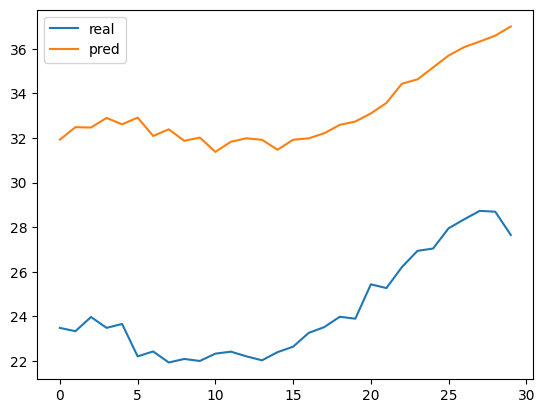

Epoch 1/1000
29/29 [==============================] - 2s 26ms/step - loss: 0.6507 - val_loss: 0.1423
Epoch 2/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.1313 - val_loss: 0.0867
Epoch 3/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.1037 - val_loss: 0.3670
Epoch 4/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.1138 - val_loss: 0.5371
Epoch 5/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.2696 - val_loss: 0.1864
Epoch 6/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.2551 - val_loss: 0.3129
Epoch 7/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.1349 - val_loss: 0.3867
Epoch 8/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.2828 - val_loss: 0.0489
Epoch 9/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.1154
Epoch 10/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.0359 - val_loss: 0.075

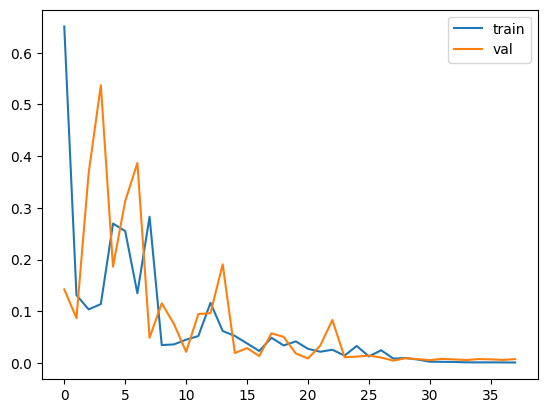

1/1 [==============================] - 0s 135ms/step
MSE: 563.1885603163759
RMSE: 23.731594137697027
(30,)
(30,)


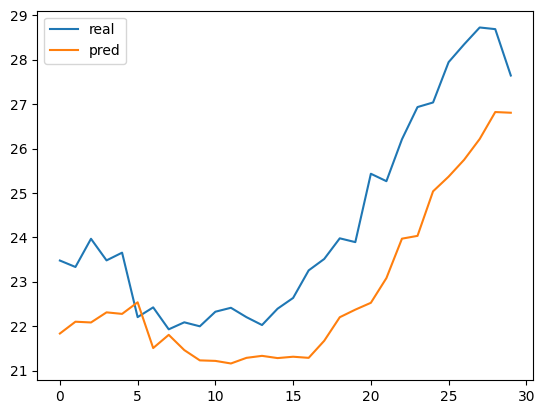

In [18]:
tscv = TimeSeriesSplit(n_splits=3)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    
    model.add(
     TCN(
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_size=5,
         dilations=[1, 2, 4, 8, 16, 32],
         return_sequences=False,
        activation='relu',
            nb_filters=64,
         padding='causal',
         #dropout_rate=0.25,
         kernel_initializer='he_normal',
     )   
    )
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape
    #print MSE and RMSE for pred and test
    mse=np.mean(np.power((y_test-y_pred),2))
    rmse=np.sqrt(mse)
    print('MSE:',mse)
    print('RMSE:',rmse)

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
